# Feature Engineering with Modelling
## Author: Dulan Wijeratne 1181873

In this notebook we will make new features using modelling techniques.

First we will start by creating a Spark session and reading in the joined aggregated data.

In [115]:
from pyspark.sql import SparkSession, functions as f

In [116]:
spark = (
    SparkSession.builder.appName("feature_engineering")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '3g')   
    .config('spark.executor.memory', '4g')  
    .config('spark.executor.instances', '2')  
    .config('spark.executor.cores', '2')
    .getOrCreate()
)

In [117]:
joined = spark.read.parquet("../../../data/curated/removed_outliers.parquet")

In [118]:
joined.orderBy(f.col("number_of_unique_consumers").desc()).show()

+------------+--------------------+-------------+------------------+----------------------------------+--------------------------+----------------------------------+--------------------------+----------------------------------------+----------------+---------------------+--------------------------+------------------------------+-------------------------+------------------------+------------------------+--------------------------+-------------------------+-------------------------+-------------------+--------------------------------+---------------------------+------------------+------------------+------------------+---------------------------------+--------------------+------------------+
|merchant_abn|                name|revenue_level|         take_rate|average_merchant_fraud_probability|number_of_unique_consumers|average_consumer_fraud_probability|number_of_repeat_consumers|average_repeat_transactions_per_consumer|number_of_orders|average_cost_of_order|average_spend_per_consumer|ave

Changing NULLs to 0s

As we are going to be using modelling techniques we need to change the NULLs to an interpretable value.

In [119]:
joined = joined.fillna(0)

Next we want to convert the categorical features into integer values so that we can check its correlation between the target variables.

In the dataset there are 2 categorical features:
- Revenue Value
- Segment

In [6]:
from pyspark.ml.feature import StringIndexer

In [7]:
input_cols = ["revenue_level","segment"]
output_cols = ["revenue_level_indexed","segment_indexed"]

In [8]:
revenue_level_indexer = StringIndexer(inputCol = "revenue_level", outputCol= "revenue_level_indexed")
segment_indexer = StringIndexer(inputCol = "segment", outputCol = "segment_indexed")

In [9]:
pre_correlation_df = revenue_level_indexer.fit(joined).transform(segment_indexer.fit(joined).transform(joined))
pre_correlation_df = pre_correlation_df.drop("revenue_level", "segment","name","first_recorded_transaction","last_recorded_transaction")

In [10]:
correlation_df = pre_correlation_df.toPandas()

Now we will check the correlation matrix

In [12]:
import pandas as pd

In [ ]:
correlation_df.head()

In [13]:
corr_matrix = correlation_df.corr()

We will matrix a heat map of the correlation matrix to view the correlations more visually.

In [ ]:
import seaborn as sns
sns.heatmap(corr_matrix)

### Feature Engineering

Predicting number of consumers in 3 years

In [14]:
corr_matrix.loc["number_of_unique_consumers"]

merchant_abn                                0.004690
take_rate                                   0.039364
average_merchant_fraud_probability         -0.005603
number_of_unique_consumers                  1.000000
average_consumer_fraud_probability         -0.144273
number_of_repeat_consumers                  0.860697
average_repeat_transactions_per_consumer    0.613602
number_of_orders                            0.714180
average_cost_of_order                      -0.180890
average_spend_per_consumer                 -0.171051
average_monthly_diff_consumers              0.773080
consumer_diff_over_period                   0.773120
average_growth_consumers                    0.442527
merchant_revenue_rounded                    0.647470
transcation_period_months                   0.243275
number_of_postcodes                         0.845176
avg_total_weekly_personal_income            0.008346
avg_total_weekly_fam_income                 0.010363
avg_median_age                             -0.

Next we seperate the features and the target variables

In [15]:
modelling_df = correlation_df.copy()

In [16]:
modelling_df.head()

,merchant_abn,take_rate,average_merchant_fraud_probability,number_of_unique_consumers,average_consumer_fraud_probability,number_of_repeat_consumers,average_repeat_transactions_per_consumer,number_of_orders,average_cost_of_order,average_spend_per_consumer,...,number_of_postcodes,avg_total_weekly_personal_income,avg_total_weekly_fam_income,avg_median_age,avg_household_size,postcode_reach,avg_num_of_consumers_per_postcode,bnpl_maximum_gain,segment_indexed,revenue_level_indexed
0,16550028284,6.52,0.0,103,0.084383,1,1.009709,104,206.620211,208.626233,...,101,821.355769,2081.072115,43.033654,2.456731,0.038272,1.029703,1401.050196,2.0,0.0
1,21437482304,5.71,0.0,47,0.000000,0,1.000000,47,310.808283,310.808283,...,47,750.159574,1876.946809,43.542553,2.435106,0.017810,1.000000,834.116235,1.0,0.0
2,68535898735,2.87,0.0,19,2.068235,0,1.000000,19,3406.956557,3406.956557,...,19,768.394737,1863.921053,42.500000,2.512632,0.007200,1.000000,1857.813205,3.0,2.0
3,27440079026,2.53,0.0,1156,0.067623,34,1.029412,1190,451.566416,464.847781,...,947,794.315546,1965.475210,43.044118,2.463672,0.358848,1.256600,13595.309805,0.0,2.0
4,53062283717,3.93,0.0,3180,0.056882,288,1.094340,3480,404.681587,442.859096,...,1869,789.271839,1973.562931,42.969971,2.460109,0.708223,1.861958,55345.873396,0.0,1.0


In [17]:
target_variable = "number_of_unique_consumers"

In [18]:
features_unique_customers = modelling_df.drop(columns = ["merchant_abn",target_variable])
number_of_unique_customer = modelling_df[target_variable]

Feature Selection

In [19]:
from sklearn.feature_selection import f_regression, SelectKBest

In [20]:
selector = SelectKBest(score_func=f_regression, k= 5)
features_unique_customers_selected = selector.fit_transform(features_unique_customers, number_of_unique_customer)

In [21]:
selected_feature_indices = selector.get_support(indices=True)
selected_features = features_unique_customers.columns[selected_feature_indices]
print(selected_features)

Index(['number_of_repeat_consumers', 'average_monthly_diff_consumers',
       'consumer_diff_over_period', 'number_of_postcodes', 'postcode_reach'],
      dtype='object')


In [22]:
# add transaction period features as this feature will be changed
selected_features = selected_features.append(pd.Index(['transcation_period_months']))
print(selected_features)

Index(['number_of_repeat_consumers', 'average_monthly_diff_consumers',
       'consumer_diff_over_period', 'number_of_postcodes', 'postcode_reach',
       'transcation_period_months'],
      dtype='object')


Splitting the data for train and test 
 - We will use a 80 - 20

In [23]:
from sklearn.model_selection import train_test_split

In [80]:
features_unique_customers_train, features_unique_customers_test, number_of_unique_customer_train, number_of_unique_customer_test = \
    train_test_split(features_unique_customers[selected_features], number_of_unique_customer, test_size=0.2, random_state=42)

### Fitting the model

First we will fit a linear regression model

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
num_of_unique_customers_model = LinearRegression()
num_of_unique_customers_model.fit((features_unique_customers_train), (number_of_unique_customer_train))

Linear Regression Model Evaluation

In [ ]:
num_of_unique_customer_pred = num_of_unique_customers_model.predict(features_unique_customers_test)
mse = mean_squared_error((number_of_unique_customer_test), (num_of_unique_customer_pred))
rmse = (mse ** 0.5)
r2 = r2_score((number_of_unique_customer_test), num_of_unique_customer_pred)

In [ ]:
print(f'R-squared (R2): {r2}')
print(f"RMSE: {rmse}")

In [ ]:
residuals = (number_of_unique_customer_test) - num_of_unique_customer_pred

In [ ]:
plt.scatter(num_of_unique_customer_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

By looking at the residual plot we can see that the underlying distribution is non-linear, so we will fit a Random Forest Regressor model.

In [121]:
from sklearn.ensemble import RandomForestRegressor

In [122]:
num_of_unique_customers_model = RandomForestRegressor()
num_of_unique_customers_model.fit((features_unique_customers_train), np.log(number_of_unique_customer_train))

RandomForestRegressor()

Random Forest Regressor Evaluation

In [123]:
num_of_unique_customer_pred = num_of_unique_customers_model.predict(features_unique_customers_test)
mse = mean_squared_error(np.log(number_of_unique_customer_test), (num_of_unique_customer_pred))
rmse = (mse ** 0.5)
r2 = r2_score(np.log(number_of_unique_customer_test), num_of_unique_customer_pred)

In [124]:
print(f'R-squared (R2): {r2}')
print(f"RMSE: {rmse}")

R-squared (R2): 0.9999449511073338
RMSE: 0.01496150240811776


In [125]:
residuals = np.log(number_of_unique_customer_test) - num_of_unique_customer_pred

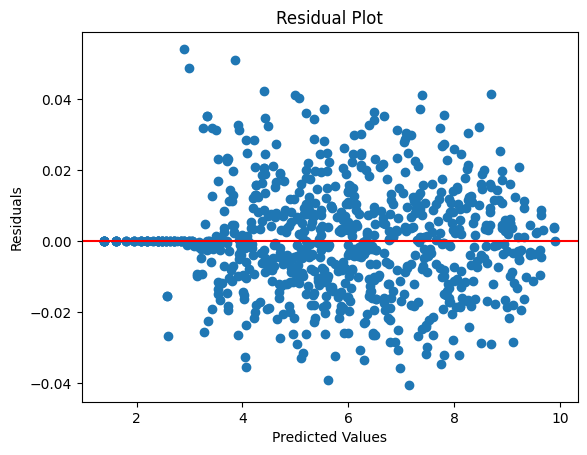

In [126]:
import matplotlib.pyplot as plt
plt.scatter(num_of_unique_customer_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

Next we will predict the number of customers in 3 years

In [127]:
future_modelling_df = modelling_df.copy()
future_modelling_df = future_modelling_df.sort_values(by='merchant_abn')

In [128]:
future_modelling_df["transcation_period_months"] = future_modelling_df["transcation_period_months"] + 36

In [129]:
future_modelling_df.head()

,merchant_abn,take_rate,average_merchant_fraud_probability,number_of_unique_consumers,average_consumer_fraud_probability,number_of_repeat_consumers,average_repeat_transactions_per_consumer,number_of_orders,average_cost_of_order,average_spend_per_consumer,...,number_of_postcodes,avg_total_weekly_personal_income,avg_total_weekly_fam_income,avg_median_age,avg_household_size,postcode_reach,avg_num_of_consumers_per_postcode,bnpl_maximum_gain,segment_indexed,revenue_level_indexed
1095,10023283211,0.18,0.0,2525,0.095502,174,1.071683,2706,215.797947,231.267028,...,1628,786.702328,1971.123799,43.031966,2.456914,0.616900,1.662162,1051.108692,2.0,4.0
2050,10142254217,4.22,0.0,2389,0.064356,151,1.064881,2544,38.591470,41.095311,...,1591,792.250000,1983.427083,42.850629,2.464025,0.602880,1.598994,4143.056534,1.0,1.0
3961,10165489824,4.40,0.0,4,6.979429,0,1.000000,4,8885.894209,8885.894209,...,4,817.500000,2066.125000,41.625000,2.475000,0.001516,1.000000,1563.917554,4.0,1.0
928,10187291046,3.29,0.0,291,0.058022,1,1.003436,292,115.995570,116.394180,...,273,796.547945,1961.171233,43.125000,2.449418,0.103448,1.069597,1114.346346,4.0,1.0
2236,10192359162,6.33,0.0,321,0.036126,2,1.006231,323,460.347109,463.215315,...,303,808.877709,2024.267802,43.294118,2.445480,0.114816,1.066007,9412.211083,0.0,0.0


In [130]:
future_features_unique_customers = future_modelling_df.drop(columns = ["merchant_abn",target_variable])

In [131]:
future_features_unique_customers.columns

Index(['take_rate', 'average_merchant_fraud_probability',
       'average_consumer_fraud_probability', 'number_of_repeat_consumers',
       'average_repeat_transactions_per_consumer', 'number_of_orders',
       'average_cost_of_order', 'average_spend_per_consumer',
       'average_monthly_diff_consumers', 'consumer_diff_over_period',
       'average_growth_consumers', 'merchant_revenue_rounded',
       'transcation_period_months', 'number_of_postcodes',
       'avg_total_weekly_personal_income', 'avg_total_weekly_fam_income',
       'avg_median_age', 'avg_household_size', 'postcode_reach',
       'avg_num_of_consumers_per_postcode', 'bnpl_maximum_gain',
       'segment_indexed', 'revenue_level_indexed'],
      dtype='object')

In [132]:
#future_features_unique_customers_poly = poly_features.fit_transform(future_features_unique_customers[selected_features])
predicted_num_of_unique_customers= num_of_unique_customers_model.predict(future_features_unique_customers[selected_features])

In [133]:
results = future_modelling_df.copy()
results["predicted_num_of_unique_customers"] = np.exp(predicted_num_of_unique_customers)

In [134]:
results.head()

,merchant_abn,take_rate,average_merchant_fraud_probability,number_of_unique_consumers,average_consumer_fraud_probability,number_of_repeat_consumers,average_repeat_transactions_per_consumer,number_of_orders,average_cost_of_order,average_spend_per_consumer,...,avg_total_weekly_personal_income,avg_total_weekly_fam_income,avg_median_age,avg_household_size,postcode_reach,avg_num_of_consumers_per_postcode,bnpl_maximum_gain,segment_indexed,revenue_level_indexed,predicted_num_of_unique_customers
1095,10023283211,0.18,0.0,2525,0.095502,174,1.071683,2706,215.797947,231.267028,...,786.702328,1971.123799,43.031966,2.456914,0.616900,1.662162,1051.108692,2.0,4.0,7.828956
2050,10142254217,4.22,0.0,2389,0.064356,151,1.064881,2544,38.591470,41.095311,...,792.250000,1983.427083,42.850629,2.464025,0.602880,1.598994,4143.056534,1.0,1.0,7.788579
3961,10165489824,4.40,0.0,4,6.979429,0,1.000000,4,8885.894209,8885.894209,...,817.500000,2066.125000,41.625000,2.475000,0.001516,1.000000,1563.917554,4.0,1.0,1.386294
928,10187291046,3.29,0.0,291,0.058022,1,1.003436,292,115.995570,116.394180,...,796.547945,1961.171233,43.125000,2.449418,0.103448,1.069597,1114.346346,4.0,1.0,5.663675
2236,10192359162,6.33,0.0,321,0.036126,2,1.006231,323,460.347109,463.215315,...,808.877709,2024.267802,43.294118,2.445480,0.114816,1.066007,9412.211083,0.0,0.0,5.778991


In [135]:
results_df = spark.createDataFrame(results)

In [136]:
results_df = results_df.select(f.col("merchant_abn"),f.col("predicted_num_of_unique_customers"))

In [137]:
joined = joined.join(results_df, on = "merchant_abn", how = "inner")

In [138]:
joined = joined.withColumn("predicted_num_of_unique_customers", f.when(joined.predicted_num_of_unique_customers < 0, 0).otherwise(f.round(joined.predicted_num_of_unique_customers)))

In [139]:
joined.orderBy(f.col("predicted_num_of_unique_customers").desc()).show()

+------------+--------------------+-------------+------------------+----------------------------------+--------------------------+----------------------------------+--------------------------+----------------------------------------+----------------+---------------------+--------------------------+------------------------------+-------------------------+------------------------+------------------------+--------------------------+-------------------------+-------------------------+-------------------+--------------------------------+---------------------------+------------------+------------------+------------------+---------------------------------+--------------------+------------------+---------------------------------+
|merchant_abn|                name|revenue_level|         take_rate|average_merchant_fraud_probability|number_of_unique_consumers|average_consumer_fraud_probability|number_of_repeat_consumers|average_repeat_transactions_per_consumer|number_of_orders|average_cost_of_or

In [ ]:
joined.write.mode("overwrite").parquet("../../../data/ranking_data.parquet")

In [ ]:
spark.stop()